<a href="https://colab.research.google.com/github/Avipsa1/UPPP275-Notebooks/blob/main/Create_hexbin_grids_of_median_home_values_with_pysal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas
!pip install libpysal
!pip install contextily cenpy
!pip install tobler
!pip install h3
!pip install mapclassify

In [5]:
import geopandas  as gpd
import matplotlib.pyplot as plt
import pandas
import libpysal
from tobler.util import h3fy
from tobler.area_weighted import area_interpolate
import contextily as ctx
from cenpy import products
import mapclassify
import h3

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [7]:
#fetch some data from the 2017 ACS
acs = products.ACS(2017)
acs

Connection to ACS 5-Year Detailed Tables(ID: https://api.census.gov/data/id/ACSDT5Y2017)
With MapServer: Census ACS 2017 WMS

In [8]:
#filter the ACS tables by those containing “value” in the description so we can find the correct variable code
acs.filter_tables('VALUE', by='description')

,description,columns
table_name,,
B25075,VALUE,"[B25075_001E, B25075_002E, B25075_003E, B25075..."
B25076,LOWER VALUE QUARTILE (DOLLARS),[B25076_001E]
B25077,MEDIAN VALUE (DOLLARS),[B25077_001E]
B25078,UPPER VALUE QUARTILE (DOLLARS),[B25078_001E]
B25079,AGGREGATE VALUE (DOLLARS) BY AGE OF HOUSEHOLDER,"[B25079_001E, B25079_002E, B25079_003E, B25079..."
B25080,AGGREGATE VALUE (DOLLARS) BY UNITS IN STRUCTURE,"[B25080_001E, B25080_002E, B25080_003E, B25080..."
B25082,AGGREGATE VALUE (DOLLARS) BY MORTGAGE STATUS,"[B25082_001E, B25082_002E, B25082_003E]"
B25083,MEDIAN VALUE (DOLLARS) FOR MOBILE HOMES,[B25083_001E]
B25096,MORTGAGE STATUS BY VALUE,"[B25096_001E, B25096_002E, B25096_003E, B25096..."


In [105]:
# we’re looking for is B25077_001E, the median home value of each. 
#Lets collect that data for the Los Angeles metropolitan region.
la = acs.from_msa('Los Angeles', variables=['B25077_001E'])
la.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


,GEOID,geometry,B25077_001E,NAME,state,county,tract
0,06037670328,"POLYGON ((-13183928.750 3998590.110, -13183871...",1627800.0,"Census Tract 6703.28, Los Angeles County, Cali...",06,037,670328
1,06037990200,"POLYGON ((-13206496.550 4033174.070, -13206119...",NaN,"Census Tract 9902, Los Angeles County, California",06,037,990200
2,06037670326,"POLYGON ((-13182706.680 4000184.830, -13182626...",1869400.0,"Census Tract 6703.26, Los Angeles County, Cali...",06,037,670326
3,06037980013,"POLYGON ((-13179812.820 4019143.240, -13179813...",NaN,"Census Tract 9800.13, Los Angeles County, Cali...",06,037,980013
4,06037602302,"POLYGON ((-13177861.170 4015210.820, -13177860...",690800.0,"Census Tract 6023.02, Los Angeles County, Cali...",06,037,602302


In [84]:
#Replace NaNs with 0
la = la.replace(np.nan,0)
la.head()

,GEOID,geometry,B25077_001E,NAME,state,county,tract
0,06037670328,"POLYGON ((-13183928.750 3998590.110, -13183871...",1627800.0,"Census Tract 6703.28, Los Angeles County, Cali...",06,037,670328
1,06037990200,"POLYGON ((-13206496.550 4033174.070, -13206119...",0.0,"Census Tract 9902, Los Angeles County, California",06,037,990200
2,06037670326,"POLYGON ((-13182706.680 4000184.830, -13182626...",1869400.0,"Census Tract 6703.26, Los Angeles County, Cali...",06,037,670326
3,06037980013,"POLYGON ((-13179812.820 4019143.240, -13179813...",0.0,"Census Tract 9800.13, Los Angeles County, Cali...",06,037,980013
4,06037602302,"POLYGON ((-13177861.170 4015210.820, -13177860...",690800.0,"Census Tract 6023.02, Los Angeles County, Cali...",06,037,602302


In [98]:
#Using the h3fy function from the tobler.util module, we can easily generate a hexgrid 
#covering the face of the LA Metropolitan region

la_hex = h3fy(la)

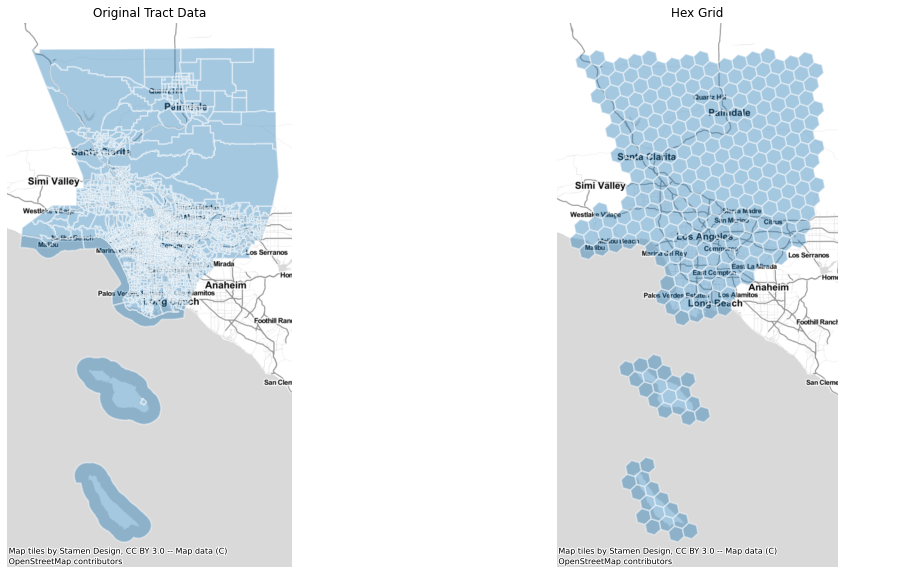

In [99]:
#Now let us plot the hexgrid on a map
fig, axs = plt.subplots(1,2, figsize=(18,10))
axs=axs.flatten()

la.plot(ax=axs[0], alpha=0.4, linewidth=1.6, edgecolor='white')
la_hex.plot(ax=axs[1], alpha=0.4, linewidth=1.6, edgecolor='white')

axs[0].set_title('Original Tract Data')
axs[1].set_title('Hex Grid')

#Add a basemap using the contextily package
for i,_ in enumerate(axs):
    ctx.add_basemap(axs[i], source=ctx.providers.Stamen.TonerLite)
    axs[i].axis('off')

In [100]:
#By altering the resolution parameter, we can generate grids using hexes of various sizes
la_hex_large = h3fy(la, resolution=5)
la_hex_small = h3fy(la, resolution=7)

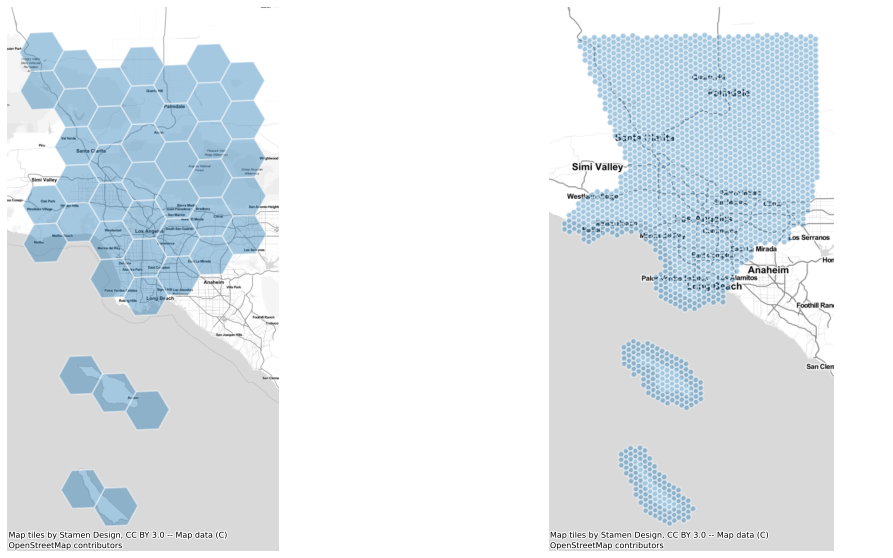

In [101]:
#Plot different size of hexbins
fig, axs = plt.subplots(1,2, figsize=(18,10))

la_hex_large.plot(ax=axs[0], alpha=0.4, linewidth=1.6, edgecolor='white')
la_hex_small.plot(ax=axs[1], alpha=0.4, linewidth=1.6, edgecolor='white')

for ax in axs:
    ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerLite)
    ax.axis('off')

In [102]:
#Use the clip parameter to  ensure that the hexgrid does not extend beyond the borders 
#of the input geodataframe

la_hex_clipped = h3fy(la, resolution=5, clip=True)

(-13242205.640969692,
 -13090063.959636511,
 3853994.0976519966,
 4153414.6972546666)

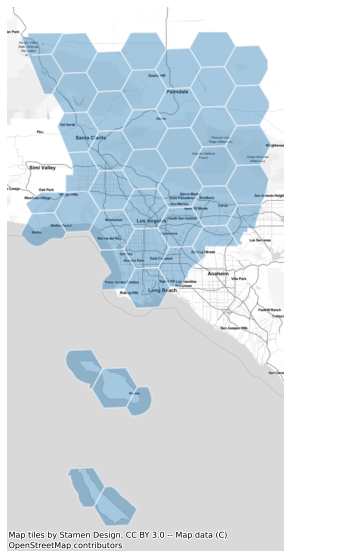

In [103]:
fig, ax = plt.subplots(figsize=(10,10))

la_hex_clipped.plot(ax=ax, alpha=0.4, linewidth=1.6, edgecolor='white')
ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerLite)
ax.axis('off')

/usr/local/lib/python3.7/dist-packages/tobler/util/util.py:32: UserWarning: nan values in variable: B25077_001E, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")


Text(0.5, 0.98, 'Spatial Interpolation of median home values in LA metro with PySAL $\\mathtt{tobler}$ package')

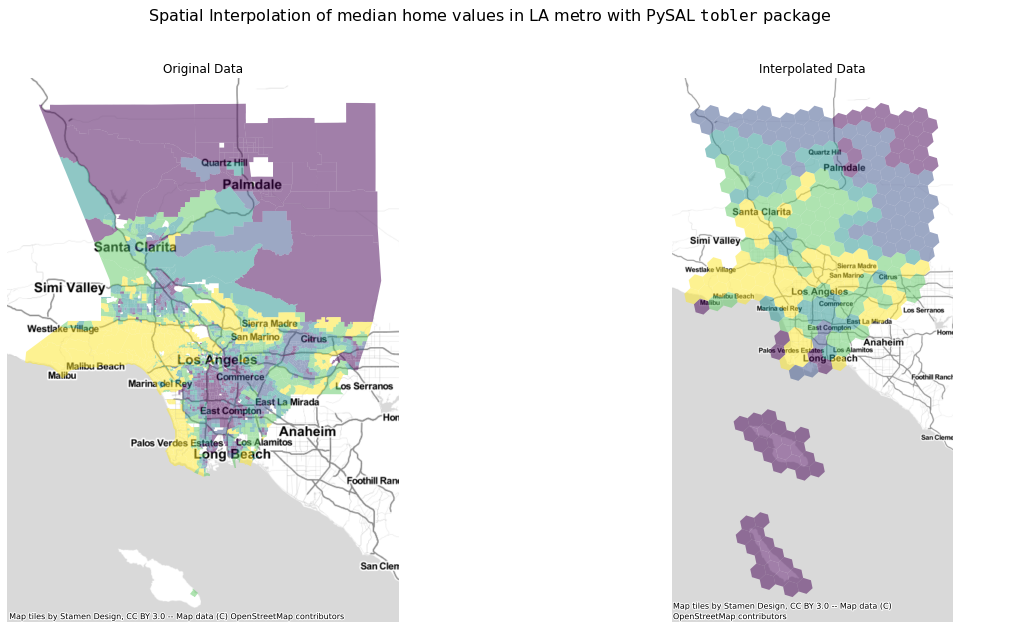

In [104]:
#Estimate the median home value of each hex in the LA region using simple areal interpolation
la_hex_interpolated = area_interpolate(source_df=la, target_df=la_hex, intensive_variables=['B25077_001E'])

#Now plot the hexbin map
fig, axs = plt.subplots(1,2, figsize=(20,10))
la.plot('B25077_001E', scheme='quantiles', alpha=0.5, ax=axs[0])

la_hex_interpolated.plot('B25077_001E', scheme='quantiles', alpha=0.5, ax=axs[1])

axs[0].set_title('Original Data')
axs[1].set_title('Interpolated Data')

for ax in axs:
    ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerLite)
    ax.axis('off')
plt.suptitle('Spatial Interpolation of median home values in LA metro with PySAL $\mathtt{tobler}$ package', fontsize=16)